In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, LayerNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import r2_score
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

In [98]:
# Laste poll-of-polls data
#df = pd.read_csv("../data/all_polls.csv", sep=",", encoding='ISO-8859-1')
#df= pd.read_csv("https://github.com/jensmorten/onesixtynine/blob/JM/data/all_polls.csv", sep=",", encoding='ISO-8859-1')
df = pd.read_csv("https://raw.githubusercontent.com/jensmorten/onesixtynine/JM/data/v2_data_august.csv", sep=",")

In [99]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667
211,8/31/2025,27.3,15.3,21.2,6.3,6.2,4.6,4.2,4.3,6.1,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.25,-0.083333,-0.041667


In [100]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [101]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [102]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_orig=df

In [103]:
df_en.head(20)

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-01-31,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,0.0
2008-02-29,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0
2008-03-31,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
2008-04-30,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
2008-05-31,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0


In [104]:
df_en=df_en.dropna()

In [105]:
split = int(len(df_en) - 3)
train_data = df_en[:split]
val_data   = df_en[split:]

In [106]:
len(val_data)

3

In [107]:
model = VAR(endog=train_data)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [108]:
model_fitted = model.fit(maxlags=len(val_data)+1,method = 'ols', trend='n', verbose=True)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Sep, 2025
Time:                     09:50:09
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -6.76740
Nobs:                     205.000    HQIC:                  -10.6287
Log likelihood:          -1150.56    FPE:                1.84942e-06
AIC:                     -13.2513    Det(Omega_mle):     3.11110e-07
--------------------------------------------------------------------
Results for equation Ap
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.Ap             -0.563990         0.410326           -1.374           0.169
L1.Hoyre          -1.513222         0.409808           -3.693           0.000
L1.Frp            -1.495999         0.408530           -3.662           0.0

In [109]:
train_r2_scores = {}
train_mae_scores = {}

for party in ["Ap","Hoyre","Frp","SV","SP","KrF","Venstre","MDG","Rodt", "Andre"]:
    y_true = train_data[party].iloc[model_fitted.k_ar:]
    y_pred = model_fitted.fittedvalues[party]
    train_r2_scores[party] = r2_score(y_true, y_pred)
    train_mae_scores[party] = mean_absolute_error(y_true, y_pred)

print("\n=== Training set metrics ===")
for party in train_r2_scores:
    print(f"{party:7s} | R²: {train_r2_scores[party]:.4f} | MAE: {train_mae_scores[party]:.4f}")



=== Training set metrics ===
Ap      | R²: 0.9542 | MAE: 0.9041
Hoyre   | R²: 0.9394 | MAE: 0.8362
Frp     | R²: 0.9573 | MAE: 0.8078
SV      | R²: 0.9604 | MAE: 0.2956
SP      | R²: 0.9595 | MAE: 0.5550
KrF     | R²: 0.8976 | MAE: 0.2114
Venstre | R²: 0.8219 | MAE: 0.2804
MDG     | R²: 0.9723 | MAE: 0.2191
Rodt    | R²: 0.9618 | MAE: 0.2824
Andre   | R²: 0.9582 | MAE: 0.2274


In [110]:
lag_order = model_fitted.k_ar
forecast_input = train_data.values[-lag_order:]  # last `lag_order` observations from training
forecast = model_fitted.forecast(y=forecast_input, steps=len(val_data))

forecast_df = pd.DataFrame(forecast, index=val_data.index, columns=val_data.columns)


In [111]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2025-06-30,30.003936,18.659040,19.764351,6.562618,5.978250,3.733601,3.775297,3.037174,4.545795,3.748652
2025-07-31,30.689505,18.727850,19.162115,6.214090,6.374244,3.609926,4.015823,2.864009,4.302085,3.769794
2025-08-31,31.105456,19.300748,18.057220,6.446819,6.295618,3.660467,4.044145,2.912973,4.236952,3.518449


In [112]:
val_data

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,4.5
2025-07-31,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,4.1
2025-08-31,27.3,15.3,21.2,6.3,6.2,4.6,4.2,4.3,6.1,4.5


In [113]:
val_r2_scores = {}
val_mae_scores = {}

for party in ["Ap","Hoyre","Frp","SV","SP","KrF","Venstre","MDG","Rodt", "Andre"]:
    y_true = val_data[party]
    y_pred = forecast_df[party]
    val_r2_scores[party] = r2_score(y_true, y_pred)
    val_mae_scores[party] = median_absolute_error(y_true, y_pred)

print("\n=== Validation set metrics ===")
for party in val_r2_scores:
    print(f"{party:7s} | R²: {val_r2_scores[party]:.4f} | MAE: {val_mae_scores[party]:.4f}")


=== Validation set metrics ===
Ap      | R²: -50.9514 | MAE: 2.9895
Hoyre   | R²: -36.2326 | MAE: 3.9279
Frp     | R²: -132.1811 | MAE: 2.3379
SV      | R²: -1.1621 | MAE: 0.3374
SP      | R²: 0.4498 | MAE: 0.0956
KrF     | R²: -0.0449 | MAE: 0.4099
Venstre | R²: -7.0336 | MAE: 0.6842
MDG     | R²: -1.7090 | MAE: 0.6360
Rodt    | R²: -186.7287 | MAE: 1.6542
Andre   | R²: -14.3469 | MAE: 0.7513


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

=== Weighted MAE & Weighted R² per maxlag ===
maxlags= 1 -> Weighted MAE=0.776007 | Weighted R²=0.091796
maxlags= 2 -> Weighted MAE=1.011575 | Weighted R²=0.004551
maxlags= 3 -> Weighted MAE=1.244393 | Weighted R²=0.002975
maxlags= 4 -> Weighted MAE=1.397501 | Weighted R²=0.043564
maxlags= 5 -> Weighted MAE=1.496484 | Weighted R²=0.050196
maxlags= 6 -> Weighted MAE=1.890369 | Weighted R²=0.029675
maxlags= 7 -> Weighted MAE=2.102204 | Weighted R²=0.047280
maxlags= 8 -> Weighted MAE=2.323518 | Weighted R²=0.035438
maxlags= 9 -> Weighted MAE=2.763520 | Weighted R²=0.019914
maxlags=10 -> Weighted MAE=3.346888 | Weighted R²=0.039865
maxlags=11 -> Weighted MAE=3.350030 | Weighted R²=0.021248
maxlags=12 -> Weighted MAE=3.535445 | Weighted R²=0.031080

Best by MAE: maxlags=1, Weighted MAE=0.776007
Best by R²:  maxlags=1, Weighted R²=0.091796


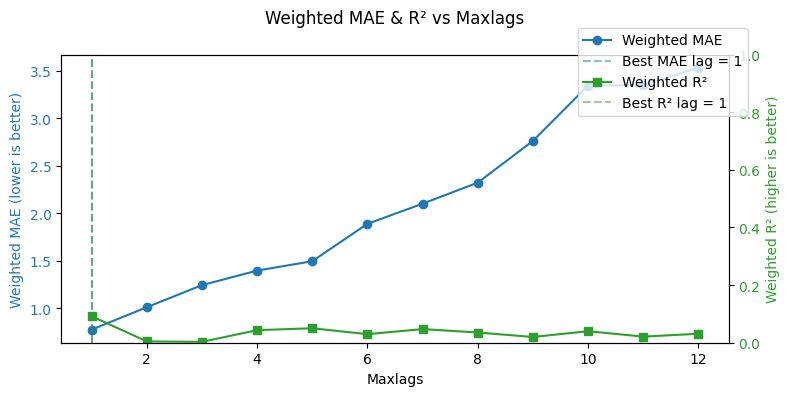

In [114]:

import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Split data
split = int(len(df_en) * 0.90)
train_data = df_en[:split]
val_data   = df_en[split:]

# Parties
parties = ["Ap","Hoyre","Frp","SV","SP","KrF","Venstre","MDG","Rodt", "Andre"]

# Compute weights: inverse of mean in training set
party_means = train_data[parties].mean()
weights = 1 / party_means
weights = weights / weights.sum()  # normalize so weights sum to 1 (optional)

# Function to compute weighted MAE and weighted R² for a given maxlags
def evaluate_maxlag(maxlags):
    try:
        model = VAR(endog=train_data)
        model_fitted = model.fit(maxlags=maxlags, method='ols', trend='n')
        lag_order = model_fitted.k_ar
        forecast_input = train_data.values[-lag_order:]
        forecast = model_fitted.forecast(y=forecast_input, steps=len(val_data))
        forecast_df = pd.DataFrame(forecast, index=val_data.index, columns=val_data.columns)

        mae_weighted_sum = 0
        r2_weighted_sum = 0

        for party in parties:
            y_true = val_data[party]
            y_pred = forecast_df[party]

            # MAE
            mae = mean_absolute_error(y_true, y_pred)
            mae_weighted_sum += mae * weights[party]

            # R² (treat negatives as 0)
            r2 = r2_score(y_true, y_pred)
            if r2 < 0:
                r2 = 0
            r2_weighted_sum += r2 * weights[party]

        return mae_weighted_sum, r2_weighted_sum
    except Exception:
        return np.inf, 0  # If model fails, set MAE to infinity and R² to 0

# Search for best maxlag
mae_results = {}
r2_results = {}

for lag in range(1, 13):  # Adjust range if needed
    mae, r2 = evaluate_maxlag(lag)
    mae_results[lag] = mae
    r2_results[lag] = r2

# Best results
best_lag_mae = min(mae_results, key=mae_results.get)
best_lag_r2 = max(r2_results, key=r2_results.get)

print("=== Weighted MAE & Weighted R² per maxlag ===")
for lag in mae_results:
    print(f"maxlags={lag:2d} -> Weighted MAE={mae_results[lag]:.6f} | Weighted R²={r2_results[lag]:.6f}")

print(f"\nBest by MAE: maxlags={best_lag_mae}, Weighted MAE={mae_results[best_lag_mae]:.6f}")
print(f"Best by R²:  maxlags={best_lag_r2}, Weighted R²={r2_results[best_lag_r2]:.6f}")

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Weighted MAE
ax1.plot(list(mae_results.keys()), list(mae_results.values()), marker='o', color='tab:blue', label='Weighted MAE')
ax1.axvline(best_lag_mae, color='tab:blue', linestyle='--', alpha=0.5, label=f'Best MAE lag = {best_lag_mae}')
ax1.set_xlabel("Maxlags")
ax1.set_ylabel("Weighted MAE (lower is better)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Weighted R² on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(list(r2_results.keys()), list(r2_results.values()), marker='s', color='tab:green', label='Weighted R²')
ax2.axvline(best_lag_r2, color='tab:green', linestyle='--', alpha=0.5, label=f'Best R² lag = {best_lag_r2}')
ax2.set_ylabel("Weighted R² (higher is better)", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_ylim(0, 1)  # R² range is between 0 and 1

fig.suptitle("Weighted MAE & R² vs Maxlags")
fig.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95))
fig.tight_layout()
plt.show()



C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

=== Weighted MAE & Weighted R² per maxlag ===
maxlags= 1 -> Weighted MAE=0.776007 | Weighted R²=0.483144
maxlags= 2 -> Weighted MAE=1.011575 | Weighted R²=0.156823
maxlags= 3 -> Weighted MAE=1.244393 | Weighted R²=0.136056
maxlags= 4 -> Weighted MAE=1.397501 | Weighted R²=0.873209
maxlags= 5 -> Weighted MAE=1.496484 | Weighted R²=1.025812
maxlags= 6 -> Weighted MAE=1.890369 | Weighted R²=0.392669
maxlags= 7 -> Weighted MAE=2.102204 | Weighted R²=0.851442
maxlags= 8 -> Weighted MAE=2.323518 | Weighted R²=0.468924
maxlags= 9 -> Weighted MAE=2.763520 | Weighted R²=0.263506
maxlags=10 -> Weighted MAE=3.346888 | Weighted R²=0.527506
maxlags=11 -> Weighted MAE=3.350030 | Weighted R²=0.281153
maxlags=12 -> Weighted MAE=3.535445 | Weighted R²=0.411253

Best by MAE: maxlags=1, Weighted MAE=0.776007
Best by R²:  maxlags=5, Weighted R²=1.025812


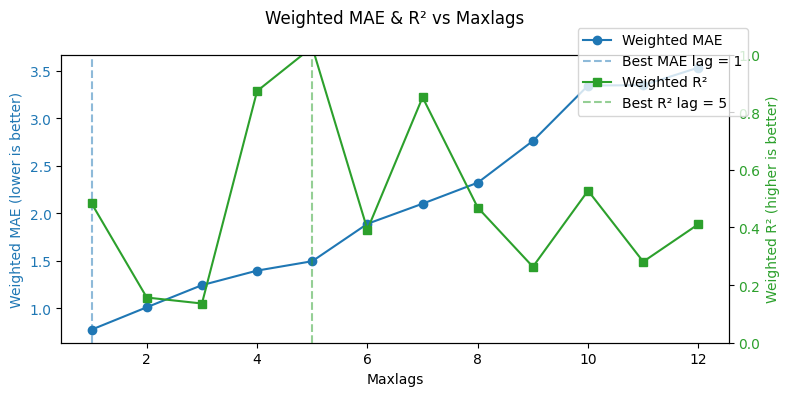

In [115]:
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Parties
parties = ["Ap","Hoyre","Frp","SV","SP","KrF","Venstre","MDG","Rodt", "Andre"]

# Compute weights: inverse of mean in training set
party_means = train_data[parties].mean()
weights = 1 / party_means
weights = weights / weights.sum()  # normalize so weights sum to 1 (optional)

# Function to compute weighted MAE and weighted R² for a given maxlags
def evaluate_maxlag(maxlags):
    try:
        model = VAR(endog=train_data)
        model_fitted = model.fit(maxlags=maxlags, method='ols', trend='n')
        lag_order = model_fitted.k_ar
        forecast_input = train_data.values[-lag_order:]
        forecast = model_fitted.forecast(y=forecast_input, steps=len(val_data))
        forecast_df = pd.DataFrame(forecast, index=val_data.index, columns=val_data.columns)

        mae_weighted_sum = 0
        r2_weighted_sum = 0

        for party in parties:
            y_true = val_data[party]
            y_pred = forecast_df[party]

            # MAE
            mae = mean_absolute_error(y_true, y_pred)
            mae_weighted_sum += mae * weights[party]

            # R² (treat negatives as 0)
            r2 = r2_score(y_true, y_pred)
            if r2 < 0:
                r2 = 0
            r2_weighted_sum += r2 #* weights[party]

        return mae_weighted_sum, r2_weighted_sum
    except Exception:
        return np.inf, 0  # If model fails, set MAE to infinity and R² to 0

# Search for best maxlag
mae_results = {}
r2_results = {}

for lag in range(1, 13):  # Adjust range if needed
    mae, r2 = evaluate_maxlag(lag)
    mae_results[lag] = mae
    r2_results[lag] = r2

# Best results
best_lag_mae = min(mae_results, key=mae_results.get)
best_lag_r2 = max(r2_results, key=r2_results.get)

print("=== Weighted MAE & Weighted R² per maxlag ===")
for lag in mae_results:
    print(f"maxlags={lag:2d} -> Weighted MAE={mae_results[lag]:.6f} | Weighted R²={r2_results[lag]:.6f}")

print(f"\nBest by MAE: maxlags={best_lag_mae}, Weighted MAE={mae_results[best_lag_mae]:.6f}")
print(f"Best by R²:  maxlags={best_lag_r2}, Weighted R²={r2_results[best_lag_r2]:.6f}")

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Weighted MAE
ax1.plot(list(mae_results.keys()), list(mae_results.values()), marker='o', color='tab:blue', label='Weighted MAE')
ax1.axvline(best_lag_mae, color='tab:blue', linestyle='--', alpha=0.5, label=f'Best MAE lag = {best_lag_mae}')
ax1.set_xlabel("Maxlags")
ax1.set_ylabel("Weighted MAE (lower is better)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Weighted R² on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(list(r2_results.keys()), list(r2_results.values()), marker='s', color='tab:green', label='Weighted R²')
ax2.axvline(best_lag_r2, color='tab:green', linestyle='--', alpha=0.5, label=f'Best R² lag = {best_lag_r2}')
ax2.set_ylabel("Weighted R² (higher is better)", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_ylim(0, 1)  # R² range is between 0 and 1

fig.suptitle("Weighted MAE & R² vs Maxlags")
fig.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95))
fig.tight_layout()
plt.show()
